In [8]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

In [9]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]
transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.8], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
per_device_batch_size = 5
num_workers = 0
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=r"FrameStrip",
                               setting=r"train.txt",
                               train=True,
                               new_length=32,
                               #video_loader=True,
                               #use_decord=True,
                               transform=transform_train)
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 40 training samples.


In [10]:
net = get_model(name='i3d_resnet50_v1_custom', nclass=101)
net.collect_params().reset_ctx(ctx)
print(net)


conv2_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm2_gamma is done with shape:  (64,)
batchnorm2_beta is done with shape:  (64,)
batchnorm2_running_mean is done with shape:  (64,)
batchnorm2_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

I3D_ResNetV1(
  (first_stage): HybridSequential(
    (0): Conv3D(3 -> 64, kernel_size=(5, 7, 7), stride=(2, 2, 2), padding=(2, 3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool3D(size=(1, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  )
  (pool2): MaxPool3D(size=(2, 1, 1), stride=(2, 1, 1), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (res_layers): HybridSequential(
    (0): HybridSequential(
      (0): Bottleneck(
        (bottleneck): HybridSequential(
          (0): Conv3D(64 -> 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
          (2): Activation(relu)
          (3): Conv3D(64 -> 64, kernel_size=(1, 3, 3), stride=(1

In [11]:
lr_decay = 0.1
lr_decay_epoch = [40, 80, 100]
optimizer = 'sgd'
optimizer_params = {'learning_rate': 0.001, 'wd': 0.0001, 'momentum': 0.9}
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [12]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()


In [13]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

[Epoch 0] train=0.625000 loss=4.188960 time: 42.464804
[Epoch 1] train=0.850000 loss=2.349616 time: 10.810051
[Epoch 2] train=0.975000 loss=0.689237 time: 10.955666


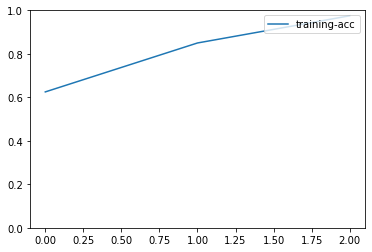

In [14]:
epochs = 3
lr_decay_count = 1

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1
    for i, batch in enumerate(train_data):
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        for l in loss:
            l.backward()

        trainer.step(batch_size)

        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc = train_metric.get()

    train_history.update([acc])
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

train_history.plot()
